# Alchemy Knowledge Graph Embeddings — Complete Pipeline

Этот ноутбук повторяет логику cs2_kge_complete, но применяет её к графу алхимии из файлов alchemy_clean.rdf / alchemy_full.rdf.

## Установка зависимостей

In [7]:
pip install pykeen pandas rdflib matplotlib scikit-learn umap-learn -q

## Импорт библиотек

In [8]:
import os
import json
import numpy as np
import pandas as pd
from rdflib import Graph, URIRef
from rdflib.namespace import RDF, RDFS
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score
import umap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Загрузка графа и подготовка троек

In [9]:
ONTO_PATH = 'alchemy_full.rdf'
if not os.path.exists(ONTO_PATH):
    raise FileNotFoundError('Не найден alchemy_full.rdf — запустите main.py для генерации или укажите путь к вашему RDF.')

g = Graph()
g.parse(ONTO_PATH, format='xml')

triples = []
label_map = {}  # uri -> rdfs:label
for s, p, o in g.triples((None, RDFS.label, None)):
    label_map[str(s)] = str(o)

for s, p, o in g:
    # Отбрасываем rdfs:label и литералы, оставляя только связи между сущностями
    if p == RDFS.label:
        continue
    if not isinstance(o, URIRef):
        continue
    triples.append((str(s), str(p), str(o)))

df = pd.DataFrame(triples, columns=['head', 'relation', 'tail'])
print('Троек (без меток):', len(df))
print('Уникальных сущностей:', pd.unique(df[['head','tail']].values.ravel()).shape[0])
print('Уникальных отношений:', df['relation'].nunique())
df.head()

Троек (без меток): 2473
Уникальных сущностей: 684
Уникальных отношений: 6


,head,relation,tail
0,http://example.org/alchemy#Recipe_Давление_Лава,http://example.org/alchemy#hasResult,http://example.org/alchemy#Вулкан
1,http://example.org/alchemy#Recipe_%D0%A1%D0%BE...,http://example.org/alchemy#hasResult,http://example.org/alchemy#%D0%9F%D0%BE%D0%B4%...
2,http://example.org/alchemy#%D0%9B%D0%B8%D1%88%...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://example.org/alchemy#Element
3,http://example.org/alchemy#%D0%A0%D1%83%D0%BC%...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://example.org/alchemy#CreatedElement
4,http://example.org/alchemy#%D0%9A%D0%BE%D0%BB%...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://example.org/alchemy#Element


## Разделение на обучающую и тестовую выборки

In [20]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print('Обучение:', len(train_df), 'Тест:', len(test_df))

train_np = train_df.to_numpy()
test_np = test_df.to_numpy()

factory_train = TriplesFactory.from_labeled_triples(train_np, create_inverse_triples=True)
factory_test = TriplesFactory.from_labeled_triples(test_np, create_inverse_triples=True, entity_to_id=factory_train.entity_to_id, relation_to_id=factory_train.relation_to_id)

Обучение: 1978 Тест: 495


## Обучение модели KGE

In [21]:
result = pipeline(
    training=factory_train,
    testing=factory_test,
    model='RotatE',
    model_kwargs={'embedding_dim': 128},
    training_kwargs=dict(num_epochs=200, batch_size=512),
    optimizer='Adam',
    optimizer_kwargs=dict(lr=1e-4)
)

print(result)
print('Метрики на тестовой выборке:')
print(result.metric_results)

INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cpu:   0%|          | 0/200 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Training batches on cpu:   0%|          | 0.00/8.00 [00:00<?, ?batch/s]

Evaluating on cpu:   0%|          | 0.00/486 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.74s seconds


PipelineResult(random_seed=1002778257, model=RotatE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): RotatEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(681, 256)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(12, 256)
    )
  )
  (weight_regularizers): ModuleList()
), training=TriplesFactory(num_entities=681, num_relations=12, create_inverse_triples=True, num_triples=1978), training_loop=<pykeen.training.slcwa.SLCWATrainingLoop object at 0x7df7f02042c0>, losses=[0.9936907812952995, 0.9918515458703041, 0.9873378723859787, 0.9819951578974724, 0.9788963124155998, 0.9762373268604279, 0.9719533175230026, 0.9712133035063744, 0.9680513516068459, 0.9638402909040451, 0.9596877545118332, 0.9577324986457825, 0.9546403586864471, 0.9471696987748146, 0.9479835256934166, 0.9447412863373756, 0.9443392157554626, 0.9364452809095383, 0.9356881901621819, 0.9

In [22]:
metrics = result.metric_results.to_dict()

def print_results(metrics):
    for key, value in metrics.items():
        print(f"\nКатегория: {key.capitalize()}")
        for scenario, metrics_data in value.items():
            print(f"  Сценарий: {scenario.capitalize()}")
            for metric_name, metric_value in metrics_data.items():
                if metric_name in ["harmonic_mean_rank", "arithmetic_mean_rank", "median_rank", "hits_at_1", "hits_at_10"]:
                    print(f"    {metric_name.replace('_', ' ').capitalize()}: {metric_value:.2f}")

print_results(metrics)


Категория: Head
  Сценарий: Optimistic
    Median rank: 275.00
    Arithmetic mean rank: 290.24
    Harmonic mean rank: 99.83
    Hits at 1: 0.00
    Hits at 10: 0.01
  Сценарий: Realistic
    Median rank: 275.00
    Arithmetic mean rank: 290.24
    Harmonic mean rank: 99.83
    Hits at 1: 0.00
    Hits at 10: 0.01
  Сценарий: Pessimistic
    Median rank: 275.00
    Arithmetic mean rank: 290.24
    Harmonic mean rank: 99.83
    Hits at 1: 0.00
    Hits at 10: 0.01

Категория: Tail
  Сценарий: Optimistic
    Median rank: 2.50
    Arithmetic mean rank: 99.23
    Harmonic mean rank: 2.07
    Hits at 1: 0.39
    Hits at 10: 0.63
  Сценарий: Realistic
    Median rank: 2.50
    Arithmetic mean rank: 99.23
    Harmonic mean rank: 2.07
    Hits at 1: 0.39
    Hits at 10: 0.63
  Сценарий: Pessimistic
    Median rank: 2.50
    Arithmetic mean rank: 99.23
    Harmonic mean rank: 2.07
    Hits at 1: 0.39
    Hits at 10: 0.63

Категория: Both
  Сценарий: Optimistic
    Median rank: 113.50
    Arit

## Извлечение эмбеддингов сущностей

In [23]:
entity_embeddings_raw = result.model.entity_representations[0]().detach().cpu().numpy()
entity_to_id = result.training.entity_to_id
id_to_entity = {v: k for k, v in entity_to_id.items()}

# PyKEEN RotatE даёт комплексные эмбеддинги; склеим вещественную и мнимую части
entity_embeddings = np.concatenate([entity_embeddings_raw.real, entity_embeddings_raw.imag], axis=1)

print('Количество сущностей:', len(entity_embeddings))
print('Размерность эмбеддинга (real+imag):', entity_embeddings.shape[1])

Количество сущностей: 681
Размерность эмбеддинга (real+imag): 256


## Кластеризация и визуализация

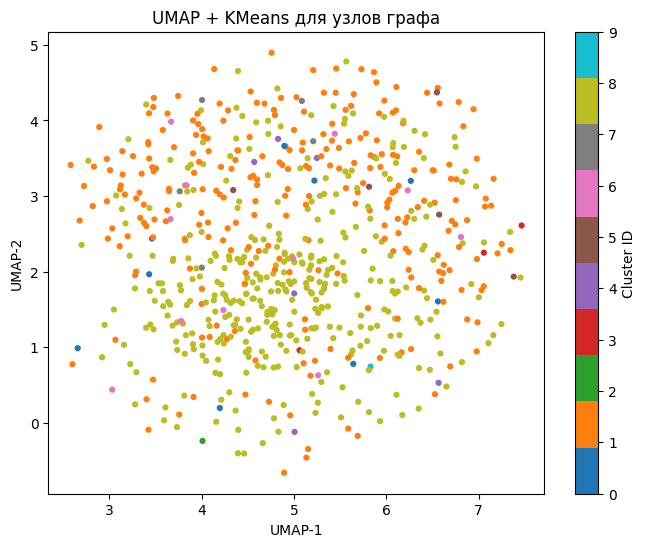

ARI по кластерам vs типу узла: 0.25330446127160255


In [24]:
# Реальные имена узлов для графиков
node_labels = [label_map.get(uri, uri.split('#')[-1]) for uri in entity_to_id]

reducer = umap.UMAP(random_state=42)
X2 = reducer.fit_transform(entity_embeddings)

n_clusters = 10  # при необходимости поменяйте
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(entity_embeddings)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X2[:,0], X2[:,1], c=clusters, cmap='tab10', s=12)
plt.title('UMAP + KMeans для узлов графа')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.colorbar(scatter, label='Cluster ID')
plt.show()

# ARI по классам, если найдены типы
class_uris = {
    'BasicElement': 'http://example.org/alchemy#BasicElement',
    'CreatedElement': 'http://example.org/alchemy#CreatedElement',
    'Recipe': 'http://example.org/alchemy#Recipe',
    'Element': 'http://example.org/alchemy#Element',
}
entity_class = {eid: None for eid in entity_to_id.values()}
for s, p, o in g.triples((None, RDF.type, None)):
    if str(o) in class_uris.values():
        if str(s) in entity_to_id:
            entity_class[entity_to_id[str(s)]] = str(o)

y_true = [entity_class[i] for i in range(len(entity_embeddings)) if entity_class[i] is not None]
y_pred = [clusters[i] for i in range(len(entity_embeddings)) if entity_class[i] is not None]
if y_true:
    ari = adjusted_rand_score(y_true, y_pred)
    print('ARI по кластерам vs типу узла:', ari)
else:
    print('Типы узлов не обнаружены в графе для ARI.')

## Классификация типа узла по эмбеддингу

In [25]:
X_cls = []
y_cls = []
for uri, idx in entity_to_id.items():
    # ищем первый подходящий тип
    node_types = [str(o) for _,_,o in g.triples((URIRef(uri), RDF.type, None)) if str(o) in class_uris.values()]
    if node_types:
        X_cls.append(entity_embeddings[idx])
        y_cls.append(node_types[0])

X_cls = np.array(X_cls)
if len(X_cls) == 0:
    raise ValueError('Не найдено ни одного узла с классами Basic/Created/Recipe.')

le = LabelEncoder()
y_enc = le.fit_transform(y_cls)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf = LogisticRegression(max_iter=300)
scores = cross_val_score(clf, X_cls, y_enc, cv=cv, scoring='accuracy')

print('Accuracy по фолдам:', scores)
print('Средняя accuracy:', scores.mean())

Accuracy по фолдам: [0.85714286 0.82959641 0.84753363]
Средняя accuracy: 0.8447576339953021


## Пример link prediction

In [26]:
import torch

# Берем первое отношение hasResult из данных
target_rel = 'http://example.org/alchemy#hasResult'
sample = df[df['relation'] == target_rel].iloc[0]
head_uri = sample['head']
true_tail = sample['tail']

print('Пример головы:', label_map.get(head_uri, head_uri))
print('Истинный tail:', label_map.get(true_tail, true_tail))

h_id = torch.tensor([entity_to_id[head_uri]])
r_id = torch.tensor([result.training.relation_to_id[target_rel]])
all_tail_ids = torch.arange(len(entity_to_id))
hrt = torch.stack([h_id.repeat(len(entity_to_id)), r_id.repeat(len(entity_to_id)), all_tail_ids], dim=1)

scores = result.model.score_hrt(hrt).detach().cpu().numpy().flatten()
tail_entities = list(entity_to_id.keys())
pred_df = pd.DataFrame({'tail': tail_entities, 'score': scores})
pred_df['label'] = pred_df['tail'].map(lambda x: label_map.get(x, x.split('#')[-1]))
pred_df = pred_df.sort_values('score', ascending=False)

print('Top-5 предсказаний для hasResult:')
print(pred_df[['label','score']].head(5))

Пример головы: Давление + Лава = Вулкан
Истинный tail: Вулкан
Top-5 предсказаний для hasResult:
                 label     score
242  Созданный элемент -2.014000
244             Рецепт -2.021502
679    NamedIndividual -2.023101
243            Элемент -2.031717
191             Страна -2.059641


## Выводы

В этом ноутбуке:
1. Загружен граф алхимии из RDF и очищены тройки от меток.
2. Построены обучающие и тестовые выборки и обучена модель RotatE.
3. Извлечены эмбеддинги, проведена кластеризация и оценка ARI по типам узлов.
4. Выполнена классификация типа узла и пример предсказания недостающей связи hasResult.